# Ablating neurons in a SPA model

The model used here is a SPA model that goes through
a set sequence of semantic pointers,
as shown in
[this NengoSPA example](https://www.nengo.ai/nengo-spa/examples/spa-sequence.html).

This is primarily a demonstration of how to apply the `ablate_ensemble` function
to all the ensembles in a network or SPA module.
If you haven't gone through the `ablate_ensemble` example
in this directory, go through that example first.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import nengo
from nengo import spa

In [2]:
dimensions = 16


def start(t):
    if t < 0.05:
        return "A"
    else:
        return "0"


with spa.SPA() as model:
    model.cortex = spa.Buffer(dimensions=dimensions)
    actions = spa.Actions(
        "dot(cortex, A) --> cortex = B",
        "dot(cortex, B) --> cortex = C",
        "dot(cortex, C) --> cortex = D",
        "dot(cortex, D) --> cortex = E",
        "dot(cortex, E) --> cortex = A",
    )
    model.bg = spa.BasalGanglia(actions=actions)
    model.thal = spa.Thalamus(model.bg)
    model.input = spa.Input(cortex=start)

    cortex = nengo.Probe(model.cortex.state.output, synapse=0.01)
    actions = nengo.Probe(model.thal.actions.output, synapse=0.01)
    utility = nengo.Probe(model.bg.input, synapse=0.01)

In [3]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/home/tbekolay/Code/nengo/nengo/builder/builder.py:234: UserWarning: Object <BasalGanglia "bg"> has already been built.
  warnings.warn(f"Object {obj} has already been built.")
/home/tbekolay/Code/nengo/nengo/builder/builder.py:234: UserWarning: Object <Thalamus "thal"> has already been built.
  warnings.warn(f"Object {obj} has already been built.")


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

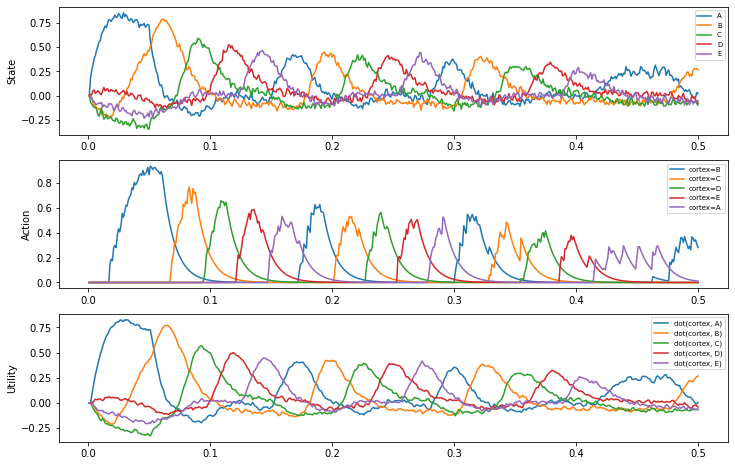

In [4]:
def plot():
    fig = plt.figure(figsize=(12, 8))
    p1 = fig.add_subplot(3, 1, 1)

    p1.plot(sim.trange(), model.similarity(sim.data, cortex))
    p1.legend(model.get_output_vocab("cortex").keys, fontsize="x-small")
    p1.set_ylabel("State")

    p2 = fig.add_subplot(3, 1, 2)
    p2.plot(sim.trange(), sim.data[actions])
    p2_legend_txt = [a.effect for a in model.bg.actions.actions]
    p2.legend(p2_legend_txt, fontsize="x-small")
    p2.set_ylabel("Action")

    p3 = fig.add_subplot(3, 1, 3)
    p3.plot(sim.trange(), sim.data[utility])
    p3_legend_txt = [a.condition for a in model.bg.actions.actions]
    p3.legend(p3_legend_txt, fontsize="x-small")
    p3.set_ylabel("Utility")

    fig.subplots_adjust(hspace=0.2)


plot()

We will use the same `ablate_ensemble` function as before.

In [5]:
def ablate_ensemble(ens, proportion, sim, bias=True):
    """Ablate a proportion of the neurons in an ensemble.

    The ablation is done by setting the encoder and gain associated
    with a neuron to zero. Since no input current being injected,
    the neuron will generally be silent. However, if there is direct
    current injected with a neuron-to-neuron connection, then the
    cell may still fire. To counter that in most cases, we set the
    bias associated with the neuron to a large negative value.
    """

    n_neurons = min(int(ens.n_neurons * proportion), ens.n_neurons)
    idx = np.random.choice(np.arange(ens.n_neurons), replace=False, size=n_neurons)

    encoder_sig = sim.signals[sim.model.sig[ens]["encoders"]]
    encoder_sig.setflags(write=True)
    encoder_sig[idx] = 0.0
    encoder_sig.setflags(write=False)

    if bias:
        bias_sig = sim.signals[sim.model.sig[ens.neurons]["bias"]]
        bias_sig.setflags(write=True)
        bias_sig[idx] = -1000

This time, however, instead of applying it to a single ensemble,
we will apply it to all of the ensembles in a SPA module.

We can therefore see the effects of ablation in different
parts of the model. Let's see what happens when ablating
25% of the neurons in the cortex.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/home/tbekolay/Code/nengo/nengo/builder/builder.py:234: UserWarning: Object <BasalGanglia "bg"> has already been built.
  warnings.warn(f"Object {obj} has already been built.")
/home/tbekolay/Code/nengo/nengo/builder/builder.py:234: UserWarning: Object <Thalamus "thal"> has already been built.
  warnings.warn(f"Object {obj} has already been built.")


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

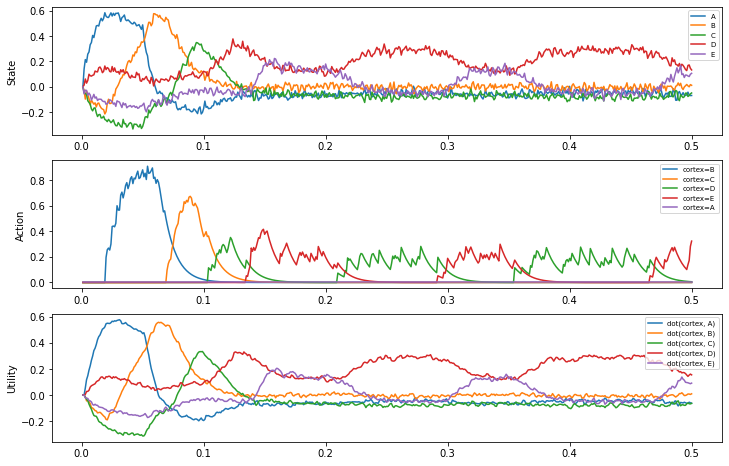

In [6]:
with nengo.Simulator(model) as sim:
    for ens in model.cortex.all_ensembles:
        ablate_ensemble(ens, 0.25, sim)
    sim.run(0.5)
plot()

In some cases, the sequence stops after some time, which is interesting!

It saves us a tiny bit of typing to make a helper function
to ablate whole networks (or SPA modules).
So let's do that, then look at the effects of ablating
the other parts of the model.

In [7]:
def ablate_network(net, proportion, sim, bias=True):
    """Ablate a proportion of the neurons in all ensembles in a network."""
    for ens in net.all_ensembles:
        ablate_ensemble(ens, proportion, sim, bias=bias)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/home/tbekolay/Code/nengo/nengo/builder/builder.py:234: UserWarning: Object <BasalGanglia "bg"> has already been built.
  warnings.warn(f"Object {obj} has already been built.")
/home/tbekolay/Code/nengo/nengo/builder/builder.py:234: UserWarning: Object <Thalamus "thal"> has already been built.
  warnings.warn(f"Object {obj} has already been built.")


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

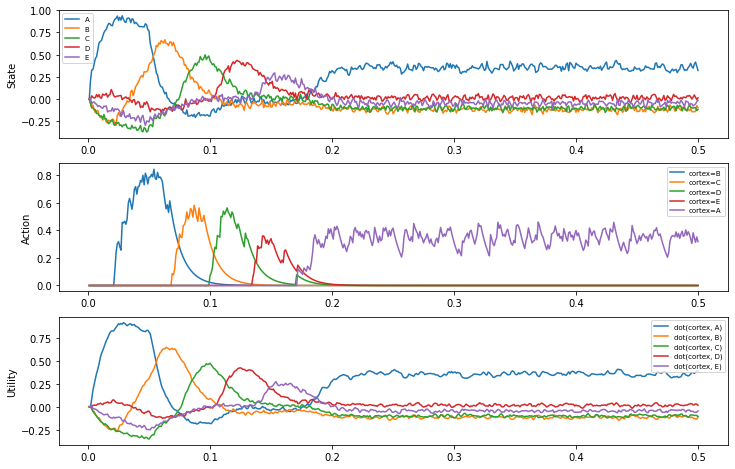

In [8]:
with nengo.Simulator(model) as sim:
    ablate_network(model.bg, 0.25, sim)
    sim.run(0.5)
plot()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/home/tbekolay/Code/nengo/nengo/builder/builder.py:234: UserWarning: Object <BasalGanglia "bg"> has already been built.
  warnings.warn(f"Object {obj} has already been built.")
/home/tbekolay/Code/nengo/nengo/builder/builder.py:234: UserWarning: Object <Thalamus "thal"> has already been built.
  warnings.warn(f"Object {obj} has already been built.")


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

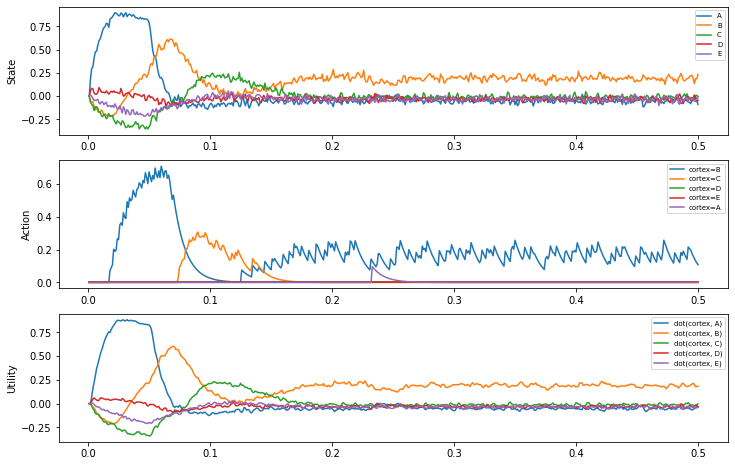

In [9]:
with nengo.Simulator(model) as sim:
    ablate_network(model.thal, 0.25, sim)
    sim.run(0.5)
plot()

Finally, let's look at what happens when we ablate
25% of the neurons in the entire model.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/home/tbekolay/Code/nengo/nengo/builder/builder.py:234: UserWarning: Object <BasalGanglia "bg"> has already been built.
  warnings.warn(f"Object {obj} has already been built.")
/home/tbekolay/Code/nengo/nengo/builder/builder.py:234: UserWarning: Object <Thalamus "thal"> has already been built.
  warnings.warn(f"Object {obj} has already been built.")


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

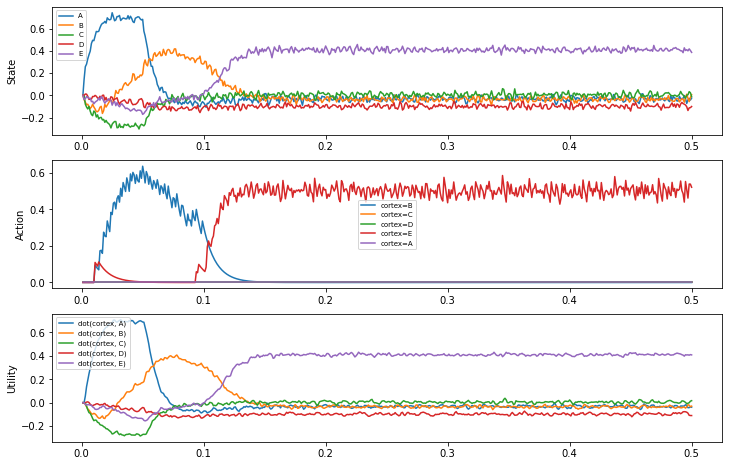

In [10]:
with nengo.Simulator(model) as sim:
    ablate_network(model, 0.25, sim)
    sim.run(0.5)
plot()

Not silencing the neurons seems to hurt performance,
possibly due to the added noise of the random spikes.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/home/tbekolay/Code/nengo/nengo/builder/builder.py:234: UserWarning: Object <BasalGanglia "bg"> has already been built.
  warnings.warn(f"Object {obj} has already been built.")
/home/tbekolay/Code/nengo/nengo/builder/builder.py:234: UserWarning: Object <Thalamus "thal"> has already been built.
  warnings.warn(f"Object {obj} has already been built.")


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

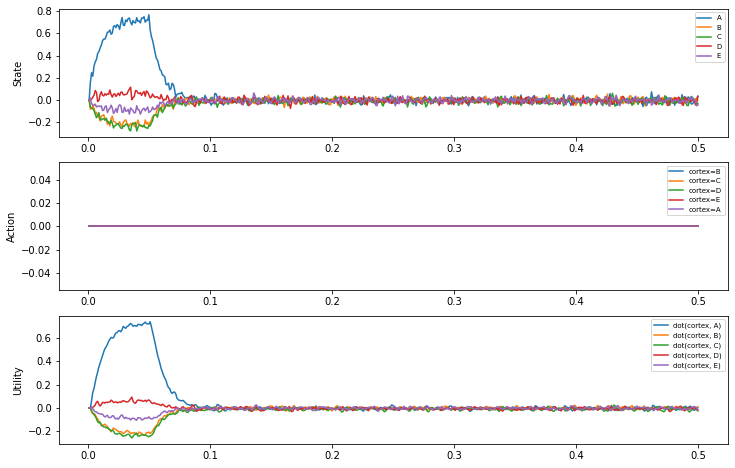

In [11]:
with nengo.Simulator(model) as sim:
    ablate_network(model, 0.25, sim, bias=False)
    sim.run(0.5)
plot()

To verify that this is indeed working as expected,
we can ablate all of the neurons and confirm that
there is no activity in the model.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/home/tbekolay/Code/nengo/nengo/builder/builder.py:234: UserWarning: Object <BasalGanglia "bg"> has already been built.
  warnings.warn(f"Object {obj} has already been built.")
/home/tbekolay/Code/nengo/nengo/builder/builder.py:234: UserWarning: Object <Thalamus "thal"> has already been built.
  warnings.warn(f"Object {obj} has already been built.")


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

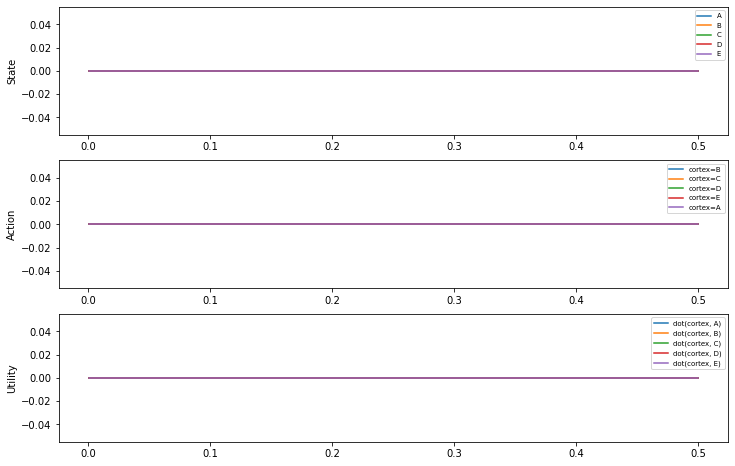

In [12]:
with nengo.Simulator(model) as sim:
    ablate_network(model, 1, sim)
    sim.run(0.5)
plot()